In [24]:
import pandas as pd
from typing import List
from pre_processing import *
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_absolute_error
import joblib
import matplotlib.pyplot as plt
import numpy as np
pd.set_option("display.max_columns", None)

## Data processing
Load data in a single dataframe and split into train and test

In [8]:
PATH = './Train/Train'

df = load_general(PATH)

df_train, df_test = train_test_split(df)

has_nan(df_train)

(True,
 station                           0
 latitude                          0
 longitude                         0
 numDocks                          0
 timestamp                         0
 year                              0
 month                             0
 day                               0
 hour                              0
 weekday                           0
 weekhour                          0
 isHoliday                         0
 windMaxSpeed.m.s                 54
 windMeanSpeed.m.s                54
 windDirection.grades            279
 temperature.C                    54
 relHumidity.HR                   54
 airPressure.mb                   54
 precipitation.l.m2               54
 bikes_3h_ago                    232
 full_profile_3h_diff_bikes     9606
 full_profile_bikes             9437
 short_profile_3h_diff_bikes    9606
 short_profile_bikes            9437
 bikes                            54
 dtype: int64)

Perform data processing and basic feature selection

In [9]:
#drop instance where there's no number of bikes
df_train = drop_nan_bikes(df_train)
df_test = drop_nan_bikes(df_test)

# #replaces days with numbers
# df_train = day_transform(df_train)
# df_test = day_transform(df_test)
df_train = pd.get_dummies(df_train,columns=['weekday'])
df_test = pd.get_dummies(df_test,columns=['weekday'])

#replaces NaN using KNN imputer
df_train = nan_impute(df_train)
df_test = nan_impute(df_test)

# #removes features with zero variance
df_train = var_transform(df_train)
df_test = var_transform(df_test)

# #has_nan(df_test)
#
df_test

,station,latitude,longitude,numDocks,timestamp,day,hour,weekhour,isHoliday,windMaxSpeed.m.s,windMeanSpeed.m.s,windDirection.grades,temperature.C,relHumidity.HR,airPressure.mb,bikes_3h_ago,full_profile_3h_diff_bikes,full_profile_bikes,short_profile_3h_diff_bikes,short_profile_bikes,bikes,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,228.0,39.475346,-0.351674,20.0,1.414544e+09,29.0,2.0,51.0,0.0,3.2,0.0,157.5,18.4,84.0,1017.3,3.0,-2.000000,2.500000,-2.000000,2.500000,18.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,230.0,39.470036,-0.334452,30.0,1.413378e+09,15.0,15.0,64.0,0.0,20.9,8.0,202.5,25.1,40.0,1010.6,7.0,0.000000,13.500000,0.000000,13.500000,22.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,232.0,39.475213,-0.336315,15.0,1.413954e+09,22.0,7.0,56.0,0.0,35.4,19.3,135.0,22.4,43.0,1022.2,7.0,0.000000,5.666667,0.000000,5.666667,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,243.0,39.463572,-0.329886,19.0,1.414541e+09,29.0,1.0,50.0,0.0,3.2,1.6,135.0,18.3,84.0,1017.4,6.0,2.666667,12.500000,2.666667,12.500000,8.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,203.0,39.476715,-0.375433,25.0,1.414476e+09,28.0,7.0,32.0,0.0,1.6,0.0,180.0,17.2,87.0,1017.9,0.0,1.000000,1.333333,1.000000,1.333333,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13943,211.0,39.463330,-0.381942,20.0,1.412705e+09,7.0,20.0,45.0,0.0,17.7,8.0,292.5,24.9,71.0,1009.6,1.0,-2.000000,2.600000,-2.000000,2.600000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
13944,212.0,39.470080,-0.365390,20.0,1.413670e+09,19.0,0.0,145.0,0.0,4.8,1.6,157.5,20.4,85.0,1023.0,4.0,-3.000000,14.000000,-3.000000,14.000000,9.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
13945,215.0,39.465974,-0.368338,20.0,1.413220e+09,13.0,19.0,20.0,0.0,22.5,12.9,180.0,23.0,43.0,1009.1,3.0,-3.000000,5.000000,-3.000000,5.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
13946,209.0,39.475002,-0.387938,16.0,1.413295e+09,14.0,16.0,41.0,0.0,25.7,9.7,157.5,21.4,44.0,1005.8,1.0,9.000000,12.000000,9.000000,12.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Find which feature has highest correlation with bikes

In [10]:
corr_matrix = correl(df_train)
print(corr_matrix['bikes'].sort_values(ascending=False).head(10))

bikes                          1.000000
bikes_3h_ago                   0.672614
short_profile_bikes            0.634640
full_profile_bikes             0.634640
longitude                      0.281977
short_profile_3h_diff_bikes    0.251771
full_profile_3h_diff_bikes     0.251771
latitude                       0.191157
numDocks                       0.122969
hour                           0.029213
Name: bikes, dtype: float64


<AxesSubplot:xlabel='short_profile_3h_diff_bikes', ylabel='bikes'>

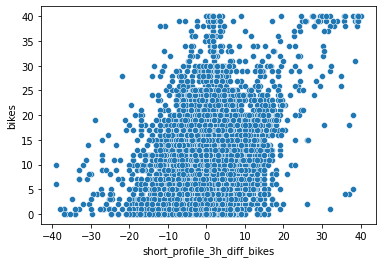

In [11]:
sns.scatterplot(data=df_train, x='short_profile_3h_diff_bikes', y='bikes')

Find inter-feature correlation and drop features with a correlation higher than 0.95

Obviously windmean and windmax are positively correlated.

['day', 'windMeanSpeed.m.s', 'short_profile_3h_diff_bikes', 'short_profile_bikes']


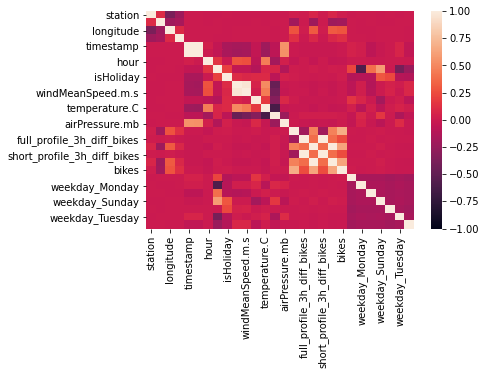

In [12]:
sns.heatmap(df_train.corr(), vmin=-1.0, vmax=1.0)

dropped = high_correl(df_train, 0.95)
dropped = high_correl(df_test, 0.95)
print(dropped)

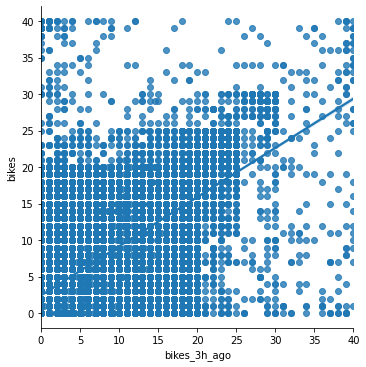

In [13]:
sns.lmplot(data= df_train, x='bikes_3h_ago', y='bikes')

Plot histograms to see whether input is Gaussian

array([[<AxesSubplot:title={'center':'station'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'numDocks'}>,
        <AxesSubplot:title={'center':'timestamp'}>],
       [<AxesSubplot:title={'center':'hour'}>,
        <AxesSubplot:title={'center':'weekhour'}>,
        <AxesSubplot:title={'center':'isHoliday'}>,
        <AxesSubplot:title={'center':'windMaxSpeed.m.s'}>,
        <AxesSubplot:title={'center':'windDirection.grades'}>],
       [<AxesSubplot:title={'center':'temperature.C'}>,
        <AxesSubplot:title={'center':'relHumidity.HR'}>,
        <AxesSubplot:title={'center':'airPressure.mb'}>,
        <AxesSubplot:title={'center':'bikes_3h_ago'}>,
        <AxesSubplot:title={'center':'full_profile_3h_diff_bikes'}>],
       [<AxesSubplot:title={'center':'full_profile_bikes'}>,
        <AxesSubplot:title={'center':'bikes'}>,
        <AxesSubplot:title={'center':'weekday_Friday'}>,
        <

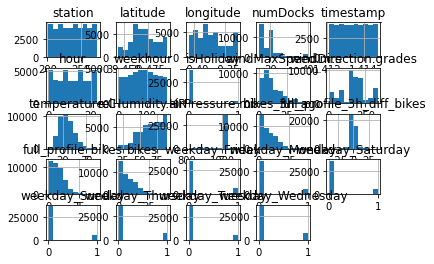

In [14]:
df_train.hist()

<AxesSubplot:>

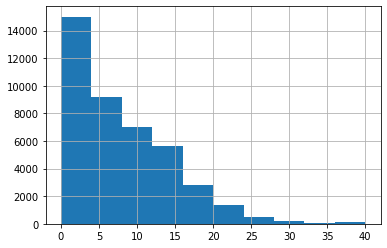

In [15]:
df_train['bikes'].hist()

Let's now investigate some categorical features

In [9]:
# #sns.set_style('darkgrid')
# #f, axes = plt.subplots(2,2, figsize = (15,15))
# sns.boxplot(data = df_train, x = 'weekday', y = 'bikes', palette="Set3")

<AxesSubplot:xlabel='isHoliday', ylabel='bikes'>

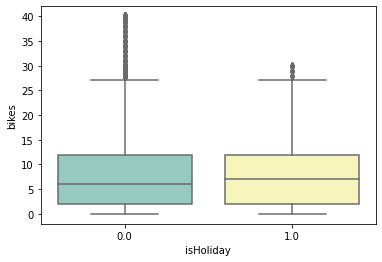

In [10]:
sns.boxplot(data = df_train, x = 'isHoliday', y = 'bikes', palette="Set3")

<AxesSubplot:xlabel='hour', ylabel='bikes'>

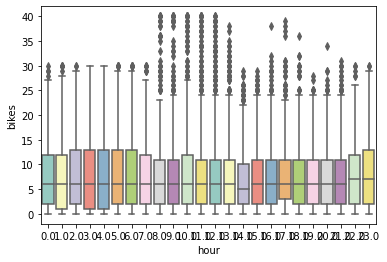

In [11]:
sns.boxplot(data = df_train, x = 'hour', y = 'bikes', palette="Set3")

## Model selection

Scale the features and impute missing data

In [16]:
#store features and target in two different dataframes
X_train = df_train.loc[:, df_train.columns != 'bikes']
Y_train = df_train['bikes']

In [17]:
X_train

,station,latitude,longitude,numDocks,timestamp,hour,weekhour,isHoliday,windMaxSpeed.m.s,windDirection.grades,temperature.C,relHumidity.HR,airPressure.mb,bikes_3h_ago,full_profile_3h_diff_bikes,full_profile_bikes,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,236.0,39.482724,-0.375973,15.0,1.414764e+09,15.0,112.0,0.0,12.9,337.5,22.4,69.0,1022.9,2.0,6.50,8.25,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,259.0,39.465639,-0.396839,15.0,1.414728e+09,5.0,102.0,0.0,1.6,225.0,17.9,86.0,1023.3,5.0,-0.25,7.50,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,240.0,39.483130,-0.380263,24.0,1.412294e+09,2.0,99.0,0.0,8.0,157.5,19.3,87.0,868.9,2.0,0.40,8.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,217.0,39.463717,-0.367085,20.0,1.413148e+09,23.0,168.0,1.0,22.5,225.0,20.6,55.0,1010.2,0.0,-8.00,3.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,202.0,39.479857,-0.379839,15.0,1.413162e+09,3.0,4.0,0.0,6.4,135.0,18.1,61.0,1010.6,2.0,-2.00,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41847,233.0,39.478548,-0.342366,40.0,1.412982e+09,1.0,122.0,0.0,17.7,225.0,23.1,62.0,1012.9,0.0,0.00,1.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0
41848,258.0,39.464900,-0.400667,15.0,1.413288e+09,14.0,39.0,0.0,16.1,180.0,18.8,58.0,1007.0,12.0,0.00,3.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0
41849,223.0,39.467747,-0.358505,20.0,1.412633e+09,0.0,25.0,0.0,6.4,180.0,21.6,82.0,1010.5,4.0,0.20,9.60,0.0,0.0,0.0,0.0,0.0,1.0,0.0
41850,242.0,39.467937,-0.331817,15.0,1.413734e+09,18.0,163.0,0.0,12.9,67.5,22.4,80.0,1023.6,15.0,-3.00,10.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [18]:
#scaled test set
# scaled_X_test = scaled_df_test.loc[:, df_test.columns != 'bikes']
# scaled_Y_test= scaled_df_test['bikes']

#unscaled test set (to see predictions)
X_test = df_test.loc[:, df_test.columns != 'bikes']
Y_test= df_test['bikes']

In [19]:
scaler = RobustScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
joblib.dump(scaler, 'scaler.joblib')

# imputer = KNNImputer(missing_values=np.nan, n_neighbors=5, weights='distance')
# X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
# X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)


['scaler.joblib']

Experiment with baseline methods

In [36]:
# pipelines = [('Linear regression', Pipeline([('Scaler', MinMaxScaler()), ("Imputer", KNNImputer(missing_values=np.nan,
#                                                                                                 n_neighbors=5, weights='distance')),('LR',LinearRegression())])),
#              ('Ridge', Pipeline([('Scaler', MinMaxScaler()),("Imputer", KNNImputer(missing_values=np.nan,
#                                                                                                 n_neighbors=5, weights='distance')),('L2',Ridge())])),
#              ('DecisionTree',Pipeline([('Scaler', MinMaxScaler()),("Imputer", KNNImputer(missing_values=np.nan,
#                                                                                                 n_neighbors=5, weights='distance')),('DT',DecisionTreeRegressor())])),
#              ('RandomForest',Pipeline([('Scaler', MinMaxScaler()),("Imputer", KNNImputer(missing_values=np.nan,
#                                                                                                 n_neighbors=5, weights='distance')),('RF',RandomForestRegressor())])),
#              ('KNN',Pipeline([('Scaler', MinMaxScaler()),("Imputer", KNNImputer(missing_values=np.nan,
#                                                                                                 n_neighbors=5, weights='distance')),('KNN',KNeighborsRegressor())])),
#            #  ('SVR',Pipeline([('Scaler', RobustScaler()),('SVR',SVR())])),
#              ('GradientBoosting', Pipeline([('Scaler', MinMaxScaler()),("Imputer", KNNImputer(missing_values=np.nan,
#                                                                                                 n_neighbors=5, weights='distance')),('GBM', GradientBoostingRegressor())]))]

pipelines = [('LR',LinearRegression()),
             ('L2',Ridge()),
             ('DT',DecisionTreeRegressor()),
             ('RF',RandomForestRegressor()),
             ('KNN',KNeighborsRegressor()),
             ('SVR',SVR()),
             ('GBM', GradientBoostingRegressor())]

#shuffle the data to preserve generality (avoids overfitting)
#df[i] = shuffle(df[i])

for model, pipeline in pipelines:
    cv_scores = cross_val_score(pipeline, X_train, Y_train, cv=5, scoring='neg_mean_absolute_error')
    print(f'Model {model} : {cv_scores.mean()}\n')

print("\n")

Model LR : -2.8602667491468265

Model L2 : -2.8603214125405416

Model DT : -2.9550978557294494



KeyboardInterrupt: 

As it is possible to see RandomForest and SVR are the ones that perform better. Let's try to tune Random Forest first

In [26]:
param_grid_forest = {'n_estimators': np.arange(100, 2000, 500),
          'max_features': ['auto', 'sqrt'],
          'max_depth': list(np.arange(5, 100, 15)) + [None],
          'min_samples_split': list(np.linspace(0.1, 1.0, 10, endpoint=True)) + [5, 10, 20],
          'min_samples_leaf': list(np.linspace(0.1, 0.5, 5, endpoint=True))+ [5, 10]
          # 'min_samples_split': [2, 5, 10],
          # 'min_samples_leaf': [1, 2, 4]
         }

tree_reg = RandomizedSearchCV(estimator = RandomForestRegressor(),
                              param_distributions = param_grid_forest, n_iter = 100,
                              verbose = 2, n_jobs = 3, cv=5, scoring='neg_mean_absolute_error')
print(f"Starting training...")
tree_reg.fit(X_train, Y_train)
joblib.dump(tree_reg.best_estimator_, "randomforest.joblib")
print(f'Best parameters for dataset are {tree_reg.best_params_}')
print(f'Best score is {tree_reg.best_score_}')

Starting training...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters for dataset are {'n_estimators': 1100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 65}
Best score is -2.238707706823697


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   20.2s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  4.3min
[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed: 32.4min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed: 45.7min finished


In [31]:
forest = joblib.load("randomforest.joblib")
predictions = forest.predict(X_test)
#predictions = tree_reg.best_estimator_.predict(X_test)
# test_error = mean_absolute_error(predictions, Y_test)
# print(f"The MAE on the test set is {test_error}\n")
#
#
sorted(dict(zip(X_train.columns, tree_reg.best_estimator_.feature_importances_)).items(), key=lambda x: x[1], reverse=True)

[('bikes_3h_ago', 0.4824085777471648),
 ('full_profile_bikes', 0.18560873919103857),
 ('full_profile_3h_diff_bikes', 0.089327227707649),
 ('numDocks', 0.0398456682463559),
 ('timestamp', 0.03566229650041093),
 ('hour', 0.024604588479433503),
 ('station', 0.02332953083194621),
 ('longitude', 0.019024024027411685),
 ('weekhour', 0.018686093603316658),
 ('latitude', 0.01703346300976159),
 ('airPressure.mb', 0.01423227933974061),
 ('temperature.C', 0.012638130551370065),
 ('relHumidity.HR', 0.010916864415192337),
 ('windMaxSpeed.m.s', 0.00883515547903637),
 ('windDirection.grades', 0.006677364611354605),
 ('isHoliday', 0.006609018889176927),
 ('weekday_Thursday', 0.0012455934209939649),
 ('weekday_Friday', 0.0008658351228526676),
 ('weekday_Saturday', 0.0007646941929058207),
 ('weekday_Wednesday', 0.0006984261290457752),
 ('weekday_Tuesday', 0.0006212000299218215),
 ('weekday_Sunday', 0.0001879362215420555),
 ('weekday_Monday', 0.0001772922523781537)]

In [32]:
prediction = pd.DataFrame(predictions, columns=['bikes'], dtype='int32')
mean_absolute_error(prediction, Y_test)

2.679093776885575

In [29]:
prediction

,bikes
0,3
1,9
2,6
3,9
4,1
...,...
13943,2
13944,4
13945,3
13946,6


In [30]:
Y_test

0        18.0
1        22.0
2         7.0
3         8.0
4         2.0
         ... 
13943     0.0
13944     9.0
13945     0.0
13946     0.0
13947     6.0
Name: bikes, Length: 13948, dtype: float64

We got an accuracy of nearly 79% on the test set.

Now tune Support Vector Machine Regressor

In [241]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train.values.astype(np.float))
# Y_train = scaler.fit_transform(Y_train.values.astype(np.float).reshape(-1, 1))

param_grid_kernel = {#'kernel': ['poly', 'rbf', 'sigmoid'],
                     #'epsilon': np.arange(0.1, 1.0, 0.1),
                     'gamma': [0.01, 0.1, 0.5, 1],
                     'C': [0.1, 1, 10, 100]
                       }
#pipe = make_pipeline(StandardScaler(), SVR())
svr_reg = GridSearchCV(estimator=SVR(),
                        param_grid = param_grid_kernel, #n_iter = 10,
                        verbose = 3, n_jobs = -3, cv=5, scoring='neg_mean_absolute_error')
print(f"Starting training...")
svr_reg.fit(X_train, Y_train)
joblib.dump(svr_reg.best_estimator_, "svr.joblib")
print(f'Best parameters for dataset are {svr_reg.best_params_}')
print(f'Best score is {svr_reg.best_score_}')

Starting training...
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done  12 tasks      | elapsed:  6.6min


KeyboardInterrupt: 

In [29]:
X_train

array([[241.        ,  39.46984411,  -0.32964496, ...,   3.        ,
          1.5       ,  11.5       ],
       [233.        ,  39.47854813,  -0.342366  , ...,   4.        ,
          0.        ,   6.25      ],
       [237.        ,  39.48567015,  -0.37859211, ...,   0.        ,
         11.        ,  12.        ],
       ...,
       [208.        ,  39.46905609,  -0.3757281 , ...,  29.        ,
         -8.25      ,  18.75      ],
       [268.        ,  39.45947405,  -0.40283117, ...,  11.        ,
          0.        ,   1.        ],
       [205.        ,  39.47078409,  -0.38270112, ...,   5.        ,
          1.5       ,   1.5       ]])